# Computer Vision

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import torchmetrics
from torchmetrics.classification import MulticlassAccuracy

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
train_data = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None # don't transform the labels
)

test_data = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None # don't transform the labels
)
class_names = train_data.classes
print(train_data.class_to_idx)
print(f"Image shape: {train_data[0][0].shape}, label: {train_data[0][1]} -> {class_names[train_data[0][1]]}")


{'T-shirt/top': 0, 'Trouser': 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4, 'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9}
Image shape: torch.Size([1, 28, 28]), label: 9 -> Ankle boot


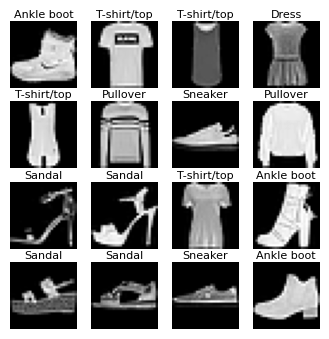

In [4]:
# Plot 16 images with more padding
fig, ax = plt.subplots(4, 4, figsize=(4, 4))
for i in range(4):
    for j in range(4):
        image = train_data[i*4+j][0]
        label = class_names[train_data[i*4+j][1]]
        ax[i][j].imshow(image.squeeze(), cmap='gray')
        ax[i][j].set_title(label, fontsize=8, pad=2.5)
        ax[i][j].axis('off')


In [5]:
# Dataloaders
from torch.utils.data import DataLoader
BATCH_SIZE = 32
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)
len(train_dataloader), len(train_dataloader.dataset)

(1875, 60000)

In [6]:
# Model
class FashionMNistModelV0(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, hidden_units),
            nn.Linear(hidden_units, output_shape)
        )
    def forward(self, x):
        return self.layer_stack(x)
            
model_0 = FashionMNistModelV0(28*28, 10, 10)

In [7]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)
accuracy = MulticlassAccuracy(task="multiclass", num_classes=len(class_names))

In [8]:
from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device = None):
    print(f"Training time on {device}: {end - start:.2f}s")



In [9]:
from tqdm.auto import tqdm

train_time_start_on_cpu = timer()
epochs = 3
for epoch in tqdm(range(epochs)):
    train_loss = 0.0
    for batch, (X, y) in enumerate(train_dataloader):
        model_0.train()
        y_pred = model_0(X)
        # calculate loss per batch
        loss = loss_fn(y_pred, y)
        # accumulate loss
        train_loss += loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % 400 == 0:
            print(f"Batch: {batch} Looked at {batch * len(X)}/{len(train_dataloader.dataset)} batches")
    
    train_loss /= len(train_dataloader)
    
    # Testing
    test_loss = 0.0 
    test_acc = 0.0
    model_0.eval()
    with torch.inference_mode():
        for X_test, y_test in test_dataloader:
            test_pred = model_0(X_test)
            test_loss += loss_fn(test_pred, y_test)
            test_acc += accuracy(test_pred, y_test)
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
    
    print(f"Epoch: {epoch+1}/{epochs}, train_loss: {train_loss:.4f}, test_loss: {test_loss:.4f}, test_acc: {test_acc:.4f}")
train_time_end_on_cpu = timer()
print_train_time(train_time_start_on_cpu, train_time_end_on_cpu, device='cpu')

  0%|          | 0/3 [00:00<?, ?it/s]

Batch: 0 Looked at 0/60000 batches
Batch: 400 Looked at 12800/60000 batches
Batch: 800 Looked at 25600/60000 batches
Batch: 1200 Looked at 38400/60000 batches
Batch: 1600 Looked at 51200/60000 batches
Epoch: 1/3, train_loss: 0.6316, test_loss: 0.5071, test_acc: 0.7980
Batch: 0 Looked at 0/60000 batches
Batch: 400 Looked at 12800/60000 batches
Batch: 800 Looked at 25600/60000 batches
Batch: 1200 Looked at 38400/60000 batches
Batch: 1600 Looked at 51200/60000 batches
Epoch: 2/3, train_loss: 0.4584, test_loss: 0.4780, test_acc: 0.8032
Batch: 0 Looked at 0/60000 batches
Batch: 400 Looked at 12800/60000 batches
Batch: 800 Looked at 25600/60000 batches
Batch: 1200 Looked at 38400/60000 batches
Batch: 1600 Looked at 51200/60000 batches
Epoch: 3/3, train_loss: 0.4312, test_loss: 0.4683, test_acc: 0.8110
Training time on cpu: 39.67s


In [10]:
# Predictions
def eval_model(model: nn.Module,
               dataloader: DataLoader,
               loss_fn: nn.Module,
               accuracy_fn
               ):
    loss, acc = 0.0, 0.0
    model.eval()
    with torch.inference_mode():
        for X, y in dataloader:
            # Make predictions
            y_pred = model(X)
            
            # Accumulate loss and acc
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_pred, y)
        
        # Average loss and acc
        loss /= len(dataloader)
        acc /= len(dataloader)
    
    return {'model_name': model.__class__.__name__, 'loss': loss.item(), 'acc': acc.item()}
            

In [11]:
model_0_results = eval_model(model_0, test_dataloader, loss_fn, accuracy)
model_0_results

{'model_name': 'FashionMNistModelV0',
 'loss': 0.46828141808509827,
 'acc': 0.8109733462333679}

## Setup device agnostic code

In [12]:
# Create a Model with non-linear and linear layers
class FashionMNistModelV1(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, output_shape),
            #nn.ReLU()
        )
    def forward(self, x):
        return self.layer_stack(x)

In [13]:
torch.manual_seed(42)
model_1 = FashionMNistModelV1(28*28, 10, 10).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.001)
accuracy = MulticlassAccuracy(task="multiclass", num_classes=len(class_names)).to(device)


## Function for training loop and evaluation/testing loop

In [14]:
def train_step(model: nn.Module,
               dataloader: DataLoader,
               loss_fn: nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = None
               ):
    train_loss = 0.0
    train_acc = 0.0
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        # calculate loss per batch
        loss = loss_fn(y_pred, y)
        
        # accumulate loss
        train_loss += loss
        train_acc += accuracy_fn(y_pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    print(f"train_loss: {train_loss:.5f}, train_acc: {train_acc:.2f}")
    
def test_step(model: nn.Module,
              dataloader: DataLoader,
              loss_fn: nn.Module,
              accuracy_fn,
              device: torch.device = None
              ):
    test_loss = 0.0
    test_acc = 0.0
    model.eval()
    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            test_loss += loss_fn(y_pred, y)
            test_acc += accuracy_fn(y_pred, y)
        test_loss /= len(dataloader)
        test_acc /= len(dataloader)
    
    print(f"test_loss: {test_loss:.5f}, test_acc: {test_acc:.2f}")

In [15]:
from tqdm.auto import tqdm
torch.manual_seed(42)
train_time_start_on_gpu = timer()

epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch+1}/{epochs}")
    train_step(model_1, train_dataloader, loss_fn, optimizer, accuracy, device)
    test_step(model_1, test_dataloader, loss_fn, accuracy, device)

train_time_end_on_gpu = timer()
print_train_time(train_time_start_on_gpu, train_time_end_on_gpu, device='gpu')


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 1/3
train_loss: 0.68001, train_acc: 0.75
test_loss: 0.51087, test_acc: 0.80
Epoch: 2/3
train_loss: 0.46397, train_acc: 0.81
test_loss: 0.47552, test_acc: 0.81
Epoch: 3/3
train_loss: 0.43398, train_acc: 0.82
test_loss: 0.46356, test_acc: 0.81
Training time on gpu: 49.48s


# Convolutional Model

In [20]:
image_height = 28
class FashionMNistModelV2(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.convo_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1), # stride=1, padding=1 keep the same size
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2) # kernel_size=2 reduce the size by half
        )
        self.convo_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*int(image_height/4)*int(image_height/4),out_features=output_shape),
        )
            
    def forward(self, x):
        x = self.convo_block_1(x)
        x = self.convo_block_2(x) 
        x = self.classifier(x)
        return x

torch.manual_seed(42)
model_2 = FashionMNistModelV2(input_shape=1, hidden_units=64,output_shape=len(class_names)).to(device)
# model_2 = torch.compile(model_2)

In [21]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.001)
accuracy = MulticlassAccuracy(task="multiclass", num_classes=len(class_names)).to(device)

In [22]:
# Train and test the model
torch.manual_seed(42)
train_time_start_on_gpu = timer()

epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch+1}/{epochs}")
    train_step(model_2, train_dataloader, loss_fn, optimizer, accuracy, device)
    test_step(model_2, test_dataloader, loss_fn, accuracy, device)

train_time_end_on_gpu = timer()
print_train_time(train_time_start_on_gpu, train_time_end_on_gpu, device='gpu')

train_loss: 0.24730, train_acc: 0.88
test_loss: 0.25039, test_acc: 0.88
Epoch: 3/3
train_loss: 0.20716, train_acc: 0.89
test_loss: 0.23530, test_acc: 0.88
Training time on gpu: 73.75s


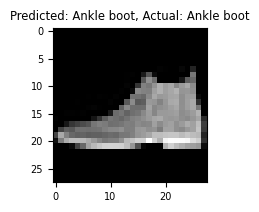

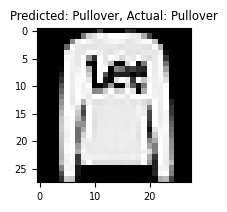

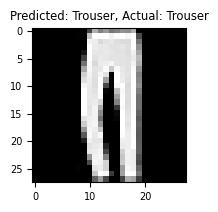

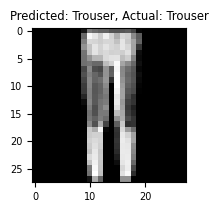

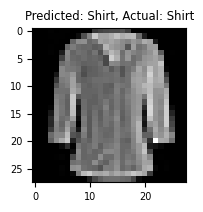

In [28]:
# Predictions
def predict(model: nn.Module, dataloader: DataLoader, count: int, device: torch.device = None):
    model.eval()
    images, labels = next(iter(dataloader))
    images, labels = images.to(device), labels.to(device)
    with torch.inference_mode():
        y_pred = model(images)
        y_pred = torch.argmax(y_pred, dim=1)
        y_pred = y_pred.cpu().numpy()
        images = images.cpu().numpy()
        labels = labels.cpu().numpy()
        for i in range(count):
            plt.figure(figsize=(2,2))
            plt.imshow(images[i][0], cmap="gray")
            plt.rcParams.update({'font.size': 7})
            plt.title(f"Predicted: {class_names[y_pred[i]]}, Actual: {class_names[labels[i]]}")
            plt.show()
            
predict(model_2, test_dataloader, 5, device)

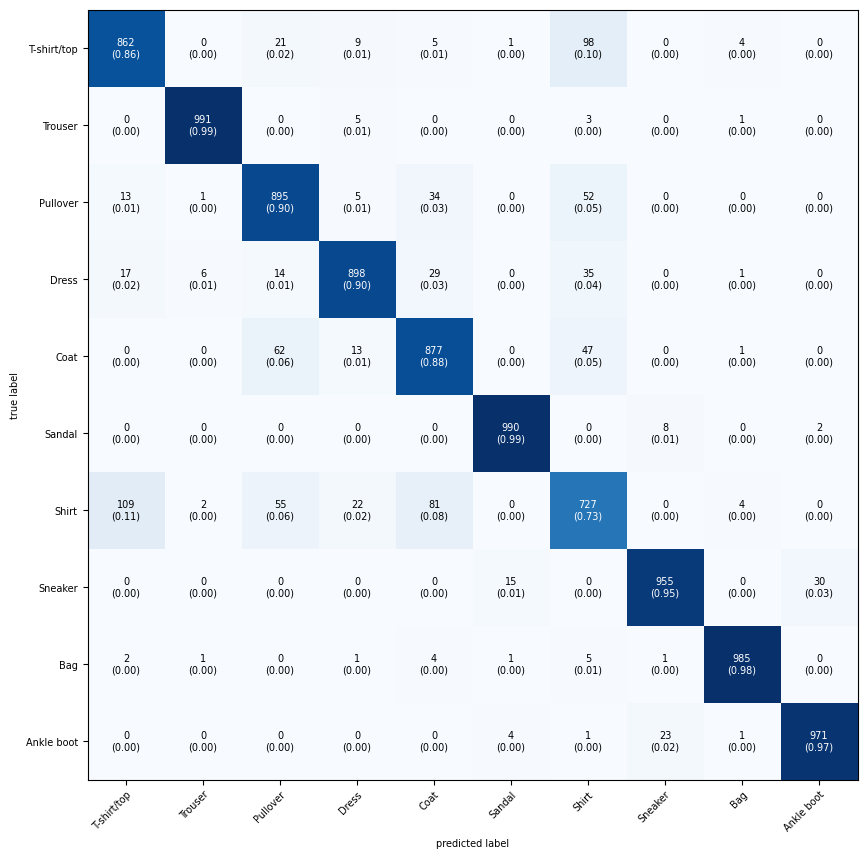

In [35]:
# Confusion Matrix
from mlxtend.plotting import plot_confusion_matrix
def confusion_matrix(model: nn.Module, dataloader: DataLoader, device: torch.device = None):
    model.eval()
    y_pred = []
    y_true = []
    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_pred.extend(torch.argmax(model(X), dim=1).cpu().numpy())
            y_true.extend(y.cpu().numpy())
    return torchmetrics.ConfusionMatrix(task="multiclass", num_classes=len(class_names))(torch.tensor(y_pred), torch.tensor(y_true))

cm = confusion_matrix(model_2, test_dataloader, device)
fig, axes = plot_confusion_matrix(cm.numpy(), figsize=(10,10), class_names=class_names, show_normed=True)